In [ ]:
!pip install swig
!pip install gymnasium[box2d]
!pip install IPython

  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373078 sha256=e4b6e50597ba906dd928a22ae424106d3c7a22275a5539cc9eb11a4a0e6d9693
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import gym
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from google.colab import drive

We will implement a SARSA with NN. The NN will map the continuous 8 feature space to the 4 actions via a hidden layer.

In [ ]:
## create a class for NN with input layer of 8, 1 hidden_size layers with ReLU
## and 4 size output layer

class NN(nn.Module):
    def __init__(self, hidden_size):
        super(NN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(8, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4))

    def forward(self, x):
        return self.network(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class DeepSarsa(object):
    def __init__(self, alpha, epsilon=0.98, epsilon_decay=1, gamma=0.98, hidden_size=64, max_iter=1000, min_epsilon=0.01):
        self.Q = None
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.env = gym.make('LunarLander-v2')
        self.env.seed(42)
        self.tot_rewards = []
        self.max_iter = max_iter
        self.min_epsilon = min_epsilon

        # NN params
        self.q_network = NN(hidden_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)
        self.best_100ma = -500

    def solve(self):
        iters = 0
        converged = False
        n_actions = self.env.action_space.n
        torch.manual_seed(3)
        np.random.seed(3)
        tot_rewards = []
        while iters < self.max_iter:
            state = self.env.reset()
            state = torch.FloatTensor(state).unsqueeze(0)
            done = False
            cur_rewards = 0

            while not done:
                # set the action based on epsilon greedy
                # since we set epsilon to 1 we just run random
                if np.random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    # calculate the argmax using torch
                    with torch.no_grad():
                        q_values = self.q_network(state)
                        action = torch.argmax(q_values).item()

                new_state, reward, done, _ = self.env.step(action)
                new_state = torch.FloatTensor(new_state).unsqueeze(0)
                cur_rewards += reward # track how well our training has been doing

                with torch.no_grad():
                    next_q_values = self.q_network(new_state)
                    next_action = torch.argmax(next_q_values).item()
                    target = reward + self.gamma * next_q_values[0][next_action]

                current_q_values = self.q_network(state)[0][action]

                # backprop
                loss = (target - current_q_values) ** 2
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                state = new_state

            # decay epsilon
            if self.epsilon_decay == 1:
                if iters > self.max_iter*0.1:
                  self.epsilon = 0.3
                if iters > self.max_iter*0.2:
                  self.epsilon = 0.2
                if iters > self.max_iter*0.3:
                  self.epsilon = 0.1
                if iters > self.max_iter*0.4:
                  self.epsilon = 0.05
                if iters > self.max_iter*0.5:
                  self.epsilon = 0.01
                if iters > self.max_iter*0.6:
                  self.epsilon = self.min_epsilon
            else:
                self.epsilon = min(self.epsilon_decay, self.min_epsilon)

            iters += 1

            # update on training
            self.tot_rewards.append(round(cur_rewards,3))
            if iters % 1000 == 0:
              print('finished ', iters ,' iterations')
              print('avg_rewards', np.mean(self.tot_rewards[-1000:]))
              print('-------------------------')

            # update best
            trailing_ma = np.mean(self.tot_rewards[-100:])

            if trailing_ma > self.best_100ma:
                torch.save(self.q_network.state_dict(), 'best_network.pth')
                self.best_100ma = trailing_ma

    def optimal_move(self, state):
        q_values = self.q_network(state)
        action = torch.argmax(q_values).item()
        return action


In [ ]:
# we will test different alpha
# we will also test if we do a 0.99 decay rather than using the stepwise decay
# would be interesting to test these throughout time, decay the alphas
# something that learns faster and gets to our target state should be used
alphas = [0.0005, 0.001, 0.002, 0.003]

# test alpha settings, assuming others constant
alpha_averages = []
alpha_rewards_list = []

for alpha in alphas:
    a = DeepSarsa(alpha=alpha, epsilon=0.99, epsilon_decay=1, max_iter=2000)
    a.solve()
    print(alpha, " ", np.mean(a.tot_rewards[-100:]))
    alpha_averages.append(np.mean(a.tot_rewards[-100:]))
    alpha_rewards_list.append(a.tot_rewards)
print(alpha_averages)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


finished  1000  iterations
avg_rewards -83.01660399999999
-------------------------
finished  2000  iterations
avg_rewards -28.464373999999996
-------------------------
0.0005   51.944320000000005


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


finished  1000  iterations
avg_rewards -95.91541499999998
-------------------------
finished  2000  iterations
avg_rewards 19.584681
-------------------------
0.001   -6.444660000000002
finished  1000  iterations
avg_rewards -67.626681
-------------------------
finished  2000  iterations
avg_rewards 148.500362
-------------------------
0.002   195.69466
finished  1000  iterations
avg_rewards -36.420632
-------------------------
finished  2000  iterations
avg_rewards 70.94699399999999
-------------------------
0.003   86.14607999999998
[51.944320000000005, -6.444660000000002, 195.69466, 86.14607999999998]


In [ ]:
# we will test different gamma
# since we will save the best network, lets go for fastest learning
gammas = [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

# test gamma settings, assuming others constant
gamma_averages = []
gamma_rewards_list = []

for gamma in gammas:
    a = DeepSarsa(alpha=0.005, epsilon=0.99, gamma=gamma, epsilon_decay=1, max_iter=2000)
    a.solve()
    print(gamma, " ", np.mean(a.tot_rewards[-100:]))
    gamma_averages.append(np.mean(a.tot_rewards[-100:]))
    gamma_rewards_list.append(a.tot_rewards)
print(gamma_averages)

In [ ]:
### Lets look at hidden layer sizes now
hidden_sizes = [16, 32, 64, 128]

# test gamma settings, assuming others constant
hidden_averages = []
hidden_rewards_list = []

for hidden_size in hidden_sizes:
    a = DeepSarsa(alpha=0.005, epsilon=0.99, gamma=0.99, epsilon_decay=1, max_iter=1000, hidden_size=hidden_size)
    a.solve()
    print(hidden_size, " ", np.mean(a.tot_rewards[-100:]))
    hidden_averages.append(np.mean(a.tot_rewards[-100:]))
    hidden_rewards_list.append(a.tot_rewards)
print(hidden_averages)

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/gdrive


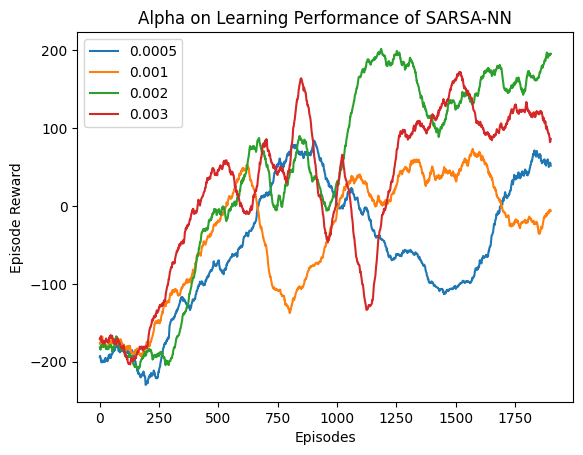

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/Colab_Images'

# Make the three plots for each variable that we tested
for n, alpha_rewards in enumerate(alpha_rewards_list):
    ma100_array = np.convolve(alpha_rewards, np.ones(100)/100, mode='valid')
    plt.plot(ma100_array, label=str(alphas[n]))
plt.title('Alpha on Learning Performance of SARSA-NN')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/alpha_nn.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

for n, gamma_rewards in enumerate(gamma_rewards_list):
    ma100_array = np.convolve(gamma_rewards, np.ones(100)/100, mode='valid')
    plt.plot(ma100_array, label=str(gammas[n]))
plt.title('Gamma on Learning Performance of SARSA-NN')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/gamma_nn.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

for n, hidden_rewards in enumerate(hidden_rewards_list):
    ma100_array = np.convolve(hidden_rewards, np.ones(100)/100, mode='valid')
    plt.plot(ma100_array, label=str(hidden_sizes[n]))
plt.title('Hidden Layer Size on Learning Performance of SARSA-NN')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/hiddensize_nn.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [ ]:
## Running optimal hyperparameters
a = DeepSarsa(alpha=0.002, epsilon=0.99, epsilon_decay=0.995, max_iter=6000)
a.solve()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


finished  1000  iterations
avg_rewards 23.925542999999998
-------------------------
finished  2000  iterations
avg_rewards 186.225538
-------------------------
finished  3000  iterations
avg_rewards 186.489248
-------------------------
finished  4000  iterations
avg_rewards 224.067274
-------------------------
finished  5000  iterations
avg_rewards 242.772581
-------------------------
finished  6000  iterations
avg_rewards 238.192168
-------------------------


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


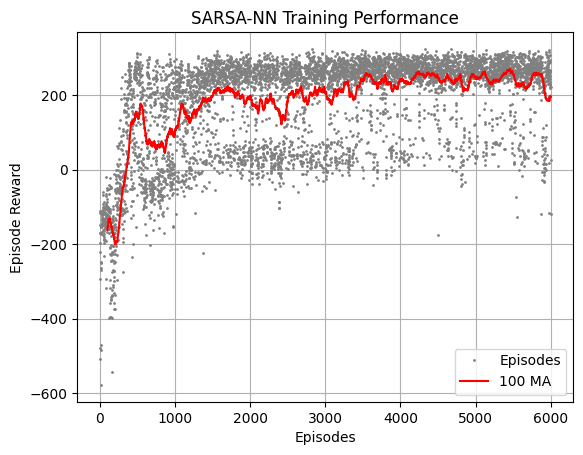

In [ ]:
results_array = np.array(a.tot_rewards)
ma_amt = 100
ma100_array = np.convolve(results_array, np.ones(ma_amt)/ma_amt, mode='valid')
plt.plot(results_array, linestyle='', marker='o', markersize=1, label='Episodes', color='grey')
plt.plot(range(100,len(results_array)+1),ma100_array, color='red', label='100 MA')
plt.title('SARSA-NN Training Performance')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.grid(True)
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/Colab_Images'
plt.savefig(f"{images_dir}/SARSA_NN.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


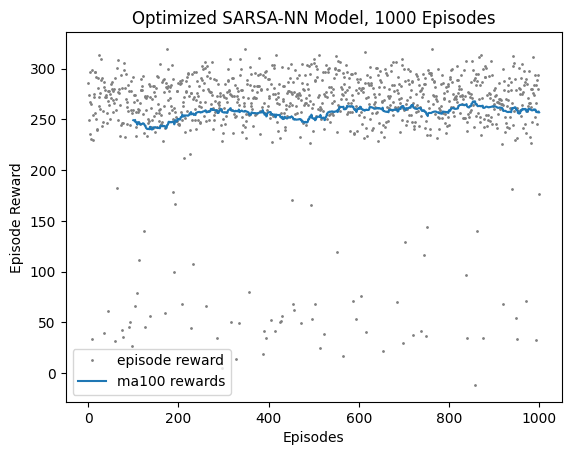

mean 256.268595
std 57.84644362996722


In [ ]:
## testing of final model

a.epsilon = 0
test_rewards = []
test_env = gym.make('LunarLander-v2')

state_dict = torch.load('best_network.pth')
best_network = NN(hidden_size)
best_network.load_state_dict(state_dict)

for i in range(1000):
    state = test_env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)
    done = False

    cur_rewards = 0
    while not done:
        with torch.no_grad():
            q_values = best_network(state)
            action = torch.argmax(q_values).item()
        new_state, reward, done, _ = test_env.step(action)
        cur_rewards += reward # track how well our training has been doing
        state = torch.FloatTensor(new_state).unsqueeze(0)
    test_rewards.append(round(cur_rewards,3))

test_rewards = np.array(test_rewards)
ma100_array = np.convolve(test_rewards, np.ones(100)/100, mode='valid')
plt.plot(test_rewards, linestyle='', marker='o', markersize=1, label='episode reward', color='grey')
plt.plot(range(100,1001), ma100_array, label='ma100 rewards')
plt.title('Optimized SARSA-NN Model, 1000 Episodes')
plt.ylabel('Episode Reward')
plt.xlabel('Episodes')
plt.legend()
plt.savefig(f"{images_dir}/final_sarsa.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

print('mean', np.mean(test_rewards))
print('std', np.std(test_rewards))

In [ ]:
# ## Animation code and visualization
# # Number of episodes
# num_episodes = 5
# def display_frames_as_gif(frames):
#     plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
#     patch = plt.imshow(frames[0])
#     plt.axis('off')
#     def animate(i):
#         patch.set_data(frames[i])
#     ani = FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
#     display(HTML(ani.to_jshtml()))

# for _ in range(num_episodes):
#     state = test_env.reset()
#     state = torch.FloatTensor(state).unsqueeze(0)
#     frames = []
#     done = False
#     cur_rewards = 0
#     while not done:
#         frames.append(test_env.render(mode='rgb_array'))
#         with torch.no_grad():
#             q_values = best_network(state)
#             action = torch.argmax(q_values).item()
#         new_state, reward, done, _ = test_env.step(action)
#         cur_rewards += reward # track how well our training has been doing
#         state = torch.FloatTensor(new_state).unsqueeze(0)
#     print(cur_rewards, reward)
#     display_frames_as_gif(frames)

# test_env.close()